In [1]:
import glob
import time
import re
import numpy as np
from functools import reduce
import random
from math import log
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
    

In [2]:
#getting all files path
def get_files(path):
    files =[]
    for file in glob.glob(path+'pos/*.*'):
        files.append(file)
    for file in glob.glob(path+'/neg/*.*'):
        files.append(file)
    return files

train_files = get_files('./dataset/train/')
test_files = get_files('./dataset/test/')

In [3]:
#reading and storing all files data,labels and ratings
def get_data(files):
    start_time = time.time()
    data = []
    labels=[]
    ratings=[]
    for file in files:
        ratings.append(int(file.split('_')[1].split('.')[0]))
        with open(file,encoding='utf-8') as f:
            raw = f.read()
            data.append(raw)
            if 'pos' in file:
                labels.append(1)
            else:
                labels.append(0)
            f.close()
    print('end-time',time.time()-start_time)
    return data,labels,ratings
train_data,train_labels,train_ratings = get_data(train_files)
test_data,test_labels,test_ratings  = get_data(test_files)        

end-time 142.61090755462646
end-time 144.077006816864


In [4]:
#reading stopwords,pos and negwords list
def get_wordlists(file):
    data = []
    with open(file,'r') as f:
        data = [i.strip("\n").lower() for i in f.readlines()]
    f.close()
    return data
stopwords = get_wordlists('./dataset/stop_words.txt')
negativewords = get_wordlists('./dataset/negative_words.txt')
positivewords = get_wordlists('./dataset/positive_words.txt')


In [5]:
#preprocessing removing every character excpet alphabets,numbers,+ and - sign.
def preprocessing(data,stopwords):
    start_time = time.time()
    tokens = [list(filter(lambda x: x not in stopwords,map(lambda x:re.sub('[^a-z0-9\-\+]+',"",x.lower().replace("\\","")),i.split(" ")))) for i in data]
    print('end-time',time.time()-start_time)
    return tokens
train_tokens = preprocessing(train_data,stopwords)
test_tokens = preprocessing(test_data,stopwords)

end-time 24.329336166381836
end-time 24.535149097442627


In [6]:
#extracting features from the processed reviews
def extract_features(tokens,positivewords,negativewords):
    start_time = time.time()
    features = [(reduce(lambda x,y:x + (y in positivewords),i,0),reduce(lambda x,y : x + (y in negativewords),i,0)) for i in tokens]
    print('end-time',time.time()-start_time)
    return features
train_features = extract_features(train_tokens,positivewords,negativewords)
test_features = extract_features(test_tokens,positivewords,negativewords)

end-time 353.9098207950592
end-time 344.0969977378845


In [7]:
#feedforward
def forward_pass(features,thetas):
    features = np.array(features)
    z = thetas[2]*1 + np.sum(features*thetas[:2],axis=1)
    return 1/(1+np.exp(-z))
thetas = np.array([0,0,0])

In [8]:
#accuracy
def compute_accuracy(predictions,labels):
    return reduce(lambda x,y: x+ (y[0]==y[1]), list(map(lambda x,y: (1,y) if x > 0.5 else (0,y),predictions,labels)),0)/len(labels)

In [9]:
#crossentropy loss
def compute_loss(predictions,labels):
    predictions = np.array(predictions)
    labels = np.array(labels)
    return np.mean( (-labels*np.log(predictions)) - ( (1-labels)*np.log(1-predictions)),axis = 0)

In [12]:
#batch gradient descent
def grad_desc(features,thetas,labels,lr,epochs):
    loss = []
    for i in range(epochs):
        predicts = forward_pass(features,thetas)
        error = compute_loss(predicts,labels)
        print(f'error for epoch#{i}',error)
        loss.append(error)
        predicts = np.array(predicts)
        labels = np.array(labels)
        thetas[0] = thetas[0] - (lr * np.mean((predicts-labels) *np.array(features)[:,0]))
        thetas[1] = thetas[1] - (lr * np.mean((predicts-labels) *np.array(features)[:,1]))
        thetas[2] = thetas[2] - (lr * np.mean((predicts-labels)))
    return thetas,loss
thetas,accuracy = grad_desc(train_features,np.array([0.,1.,1.]),train_labels,0.01,1300)       

55175121
error for epoch#793 0.5762672561634237
error for epoch#794 0.5762443854534645
error for epoch#795 0.5762215433533762
error for epoch#796 0.5761987298289368
error for epoch#797 0.57617594484596
error for epoch#798 0.5761531883702953
error for epoch#799 0.5761304603678282
error for epoch#800 0.5761077608044803
error for epoch#801 0.576085089646209
error for epoch#802 0.5760624468590069
error for epoch#803 0.576039832408903
error for epoch#804 0.5760172462619622
error for epoch#805 0.5759946883842844
error for epoch#806 0.5759721587420059
error for epoch#807 0.5759496573012987
error for epoch#808 0.5759271840283698
error for epoch#809 0.5759047388894628
error for epoch#810 0.5758823218508562
error for epoch#811 0.5758599328788644
error for epoch#812 0.5758375719398372
error for epoch#813 0.5758152390001604
error for epoch#814 0.5757929340262548
error for epoch#815 0.575770656984577
error for epoch#816 0.5757484078416191
error for epoch#817 0.5757261865639084
error for epoch#818 0

Final Loss on Training Data 0.5677057686873969


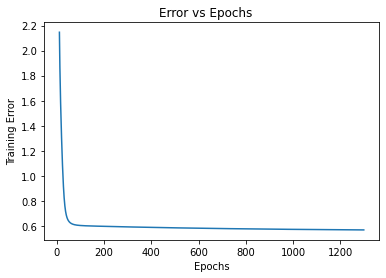

In [14]:
#plotting
def plot(loss):
    epochs = list(range(len(loss)))
    print('Final Loss on Training Data',loss[-1])
    plt.plot(epochs,accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Training Error')
    plt.title('Error vs Epochs   ')
    plt.show()
plot(accuracy)

In [15]:
#metrics
def report(features,labels,thetas):
        predictions = forward_pass(features,thetas)
        print("Accuracy on Test Data",compute_accuracy(predictions,labels))
        predictions = list(map(lambda x : 1 if x > 0.5 else 0,predictions))
        combined = list(map(lambda x,y: (x,y),predictions,labels))
        metrics = [0] 
        metrics =(reduce(lambda x,y: x+ (y[0] ==1 and y[1] ==1),combined,0),
                 reduce(lambda x,y: x+ (y[0] ==0 and y[1] ==0),combined,0),
                 reduce(lambda x,y: x+ (y[0] ==1 and y[1] ==0),combined,0),
                 reduce(lambda x,y: x+ (y[0] ==0 and y[1] ==1),combined,0))
        print("True Positives:",metrics[0])
        print("True Negatives:",metrics[1])
        print("False Positives",metrics[2])
        print("False Negatives",metrics[3])      
report(test_features,test_labels,thetas)


Accuracy on Test Data 0.72104
True Positives: 9945
True Negatives: 8081
False Positives 4419
False Negatives 2555


In [16]:
model = LogisticRegression().fit(train_features,train_labels)
predictions = model.predict(train_features)
print('Accuracy on Training Data',accuracy_score(predictions,train_labels))
predictions = model.predict(test_features)
print('Accuracy on Test Data',accuracy_score(predictions,test_labels))
metrics = confusion_matrix(predictions,test_labels,labels=[1,0]).ravel()
print("True Positives:",metrics[0])
print("True Negatives:",metrics[1])
print("False Positives",metrics[2])
print("False Negatives",metrics[3])

Accuracy on Training Data 0.7256
Accuracy on Test Data 0.73112
True Positives: 9127
True Negatives: 3349
False Positives 3373
False Negatives 9151
